# OCR Experiment

## 1. Setup and Libraries

In [12]:
import easyocr
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from difflib import SequenceMatcher

## 2. Initialize EasyOCR

In [13]:
reader = easyocr.Reader(['th'], gpu=False)
ALLOWLIST = "".join(chr(c) for c in range(0x0E01, 0x0E3B)) + "0123456789 "
print(f"EasyOCR initialized with {len(ALLOWLIST)} allowed characters (including space)")

Using CPU. Note: This module is much faster with a GPU.


EasyOCR initialized with 69 allowed characters (including space)


## 3. Improved OCR Functions

In [14]:
def aggressive_preprocess(img):
    """More aggressive preprocessing for difficult images."""
    # Higher contrast enhancement
    img_contrast = ImageEnhance.Contrast(img).enhance(1.8)

    # More aggressive sharpening
    img_sharp = img_contrast.filter(
        ImageFilter.UnsharpMask(radius=2.0, percent=200, threshold=1)
    )

    return img_sharp


def run_improved_ocr(img):
    """Run OCR with improved parameters for better accuracy."""
    processed_img = aggressive_preprocess(img)
    arr = np.array(processed_img)

    # More sensitive parameters
    results = reader.readtext(
        arr,
        detail=1,
        paragraph=False,
        contrast_ths=0.02,  # More sensitive to contrast
        adjust_contrast=0.9,  # Stronger contrast adjustment
        text_threshold=0.4,  # Lower threshold for text detection
        low_text=0.15,  # Detect very faint text
        link_threshold=0.3,  # Better text linking
        allowlist=ALLOWLIST,
        decoder="beamsearch",
        rotation_info=[0, 90, -90],
    )

    return results, processed_img


def clean_detected_text(text):
    """Clean and normalize detected text."""
    # Remove extra spaces and normalize
    cleaned = re.sub(r"\s+", " ", text.strip())
    return cleaned


def similarity(a, b):
    """Calculate similarity between two strings."""
    return SequenceMatcher(None, a, b).ratio()


def smart_match(detected_text, ground_truth_label, threshold=0.7):
    """Smart matching with fuzzy string comparison."""
    detected_clean = clean_detected_text(detected_text)
    gt_clean = clean_detected_text(ground_truth_label)

    # Exact match
    if detected_clean == gt_clean:
        return True, 1.0, "Exact match"

    # Partial match (one contains the other)
    if detected_clean in gt_clean or gt_clean in detected_clean:
        return True, 0.9, "Partial match"

    # Fuzzy match
    sim_score = similarity(detected_clean, gt_clean)
    if sim_score >= threshold:
        return True, sim_score, f"Fuzzy match ({sim_score:.2f})"

    return False, sim_score, f"No match ({sim_score:.2f})"


def filter_relevant_detections(results):
    """Filter out irrelevant detections like long numbers."""
    filtered = []
    for bbox, text, conf in results:
        text_clean = clean_detected_text(text)

        # Skip very long numbers (likely metadata)
        if re.match(r"^\d{8,}$", text_clean):
            continue

        # Skip very short single characters with low confidence
        if len(text_clean) == 1 and conf < 0.7:
            continue

        filtered.append((bbox, text_clean, conf))

    return filtered


print("Improved OCR functions defined")

Improved OCR functions defined


## 4. Load Images and Ground Truth

In [15]:
def load_ground_truth(filename):
    """Load ground truth labels from .txt file."""
    label_filename = filename.replace('.jpg', '.txt')
    try:
        with open(label_filename, 'r', encoding='utf-8') as f:
            labels = [line.strip() for line in f.readlines() if line.strip()]
        return labels
    except FileNotFoundError:
        print(f"Warning: {label_filename} not found")
        return []

# Load test images
image_files = ['license-plate-th.jpg', 'license-plate-th2.jpg', 'license-plate-th3.jpg']
test_images = {}
ground_truth_labels = {}

print("Loading test images and ground truth:")
for filename in image_files:
    if os.path.exists(filename):
        img = Image.open(filename).convert('RGB')
        test_images[filename] = img
        
        gt_labels = load_ground_truth(filename)
        ground_truth_labels[filename] = gt_labels
        
        print(f"LOADED {filename}: {gt_labels}")
    else:
        print(f"MISSING {filename}: Not found")

print(f"\nLoaded {len(test_images)} images with {sum(len(labels) for labels in ground_truth_labels.values())} total labels")

Loading test images and ground truth:
LOADED license-plate-th.jpg: ['กก 555', 'กรุงทพมหานคร']
LOADED license-plate-th2.jpg: ['ซค 5', 'หนองบัวลำภู']
LOADED license-plate-th3.jpg: ['กท 2058', 'ฉะชิงเทรา']

Loaded 3 images with 6 total labels


## 5. Run Improved OCR Experiments

In [ ]:
# Test different approaches
approaches = {
    "Original": {
        "confidence_threshold": 0.5,
        "use_aggressive_preprocessing": False,
        "use_smart_matching": False,
    },
    "Lower_Threshold": {
        "confidence_threshold": 0.3,
        "use_aggressive_preprocessing": False,
        "use_smart_matching": False,
    },
    "Aggressive_Preprocessing": {
        "confidence_threshold": 0.5,
        "use_aggressive_preprocessing": True,
        "use_smart_matching": False,
    },
    "Smart_Matching": {
        "confidence_threshold": 0.5,
        "use_aggressive_preprocessing": False,
        "use_smart_matching": True,
    },
    "Combined_Improved": {
        "confidence_threshold": 0.3,
        "use_aggressive_preprocessing": True,
        "use_smart_matching": True,
    },
}

results_by_approach = {}

print("TESTING DIFFERENT APPROACHES TO IMPROVE ACCURACY")
print("=" * 80)

for approach_name, config in approaches.items():
    print(f"\nTesting: {approach_name}")
    print(f"   Config: {config}")
    print("-" * 60)

    approach_results = {}
    total_matches = 0
    total_labels = 0

    for filename, img in test_images.items():
        ground_truth = ground_truth_labels[filename]
        total_labels += len(ground_truth)

        # Run OCR
        if config["use_aggressive_preprocessing"]:
            results, processed_img = run_improved_ocr(img)
        else:
            # Original preprocessing
            processed_img = img
            arr = np.array(img)
            results = reader.readtext(
                arr,
                detail=1,
                paragraph=False,
                contrast_ths=0.05,
                adjust_contrast=0.7,
                text_threshold=0.6,
                low_text=0.3,
                link_threshold=0.4,
                allowlist=ALLOWLIST,
                decoder="beamsearch",
            )

        # Filter detections
        filtered_results = filter_relevant_detections(results)

        # Filter by confidence
        high_conf_results = [
            (bbox, text, conf)
            for bbox, text, conf in filtered_results
            if conf >= config["confidence_threshold"]
        ]

        detected_texts = [text for _, text, _ in high_conf_results]

        print(f"\n{filename}:")
        print(f"   Ground Truth: {ground_truth}")
        print(f"   Detected: {detected_texts}")

        # Calculate matches
        image_matches = 0
        match_details = []

        for gt_label in ground_truth:
            best_match = False
            best_score = 0
            best_reason = ""
            best_detected = ""

            for detected_text in detected_texts:
                if config["use_smart_matching"]:
                    is_match, score, reason = smart_match(detected_text, gt_label)
                else:
                    # Simple matching
                    is_match = (
                        gt_label == detected_text
                        or gt_label in detected_text
                        or detected_text in gt_label
                    )
                    score = 1.0 if is_match else 0.0
                    reason = "Simple match" if is_match else "No match"

                if is_match and score > best_score:
                    best_match = True
                    best_score = score
                    best_reason = reason
                    best_detected = detected_text

            if best_match:
                image_matches += 1
                total_matches += 1
                print(f"   MATCH '{gt_label}' ~ '{best_detected}' ({best_reason})")
            else:
                print(f"   MISS '{gt_label}' - No match found")

        image_accuracy = (
            (image_matches / len(ground_truth)) * 100 if ground_truth else 0
        )
        print(
            f"   Image Accuracy: {image_matches}/{len(ground_truth)} = {image_accuracy:.1f}%"
        )

        approach_results[filename] = {
            "matches": image_matches,
            "total": len(ground_truth),
            "accuracy": image_accuracy,
            "detected": detected_texts,
        }

    overall_accuracy = (total_matches / total_labels) * 100 if total_labels > 0 else 0
    approach_results["overall"] = {
        "matches": total_matches,
        "total": total_labels,
        "accuracy": overall_accuracy,
    }

    results_by_approach[approach_name] = approach_results

    print(
        f"\n{approach_name} Overall: {total_matches}/{total_labels} = {overall_accuracy:.1f}%"
    )

print("\nAll approaches tested!")

TESTING DIFFERENT APPROACHES TO IMPROVE ACCURACY

Testing: Original
   Config: {'confidence_threshold': 0.5, 'use_aggressive_preprocessing': False, 'use_smart_matching': False}
------------------------------------------------------------


/Users/tae/chula/25/1/iot/Lab/license_plate_ocr/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



license-plate-th.jpg:
   Ground Truth: ['กก 555', 'กรุงทพมหานคร']
   Detected: ['กก', '555', 'กรุงทพมหานคร']
   MATCH 'กก 555' ~ 'กก' (Simple match)
   MATCH 'กรุงทพมหานคร' ~ 'กรุงทพมหานคร' (Simple match)
   Image Accuracy: 2/2 = 100.0%

license-plate-th2.jpg:
   Ground Truth: ['ซค 5', 'หนองบัวลำภู']
   Detected: ['ซค5', 'ทนองบัวลำภู']
   MISS 'ซค 5' - No match found
   MISS 'หนองบัวลำภู' - No match found
   Image Accuracy: 0/2 = 0.0%

license-plate-th2.jpg:
   Ground Truth: ['ซค 5', 'หนองบัวลำภู']
   Detected: ['ซค5', 'ทนองบัวลำภู']
   MISS 'ซค 5' - No match found
   MISS 'หนองบัวลำภู' - No match found
   Image Accuracy: 0/2 = 0.0%

license-plate-th3.jpg:
   Ground Truth: ['กท 2058', 'ฉะชิงเทรา']
   Detected: ['กท 2058', 'ฉะชิงททรา']
   MATCH 'กท 2058' ~ 'กท 2058' (Simple match)
   MISS 'ฉะชิงเทรา' - No match found
   Image Accuracy: 1/2 = 50.0%

Original Overall: 3/6 = 50.0%

Testing: Lower_Threshold
   Config: {'confidence_threshold': 0.3, 'use_aggressive_preprocessing': False, 'us

## 6. Comparison Results

In [ ]:
print("APPROACH COMPARISON RESULTS")
print("=" * 80)

# Sort approaches by overall accuracy
sorted_approaches = sorted(
    results_by_approach.items(), key=lambda x: x[1]["overall"]["accuracy"], reverse=True
)

print(f"{'Rank':<4} {'Approach':<25} {'Accuracy':<10} {'Matches':<10}")
print("-" * 55)

for rank, (approach_name, results) in enumerate(sorted_approaches, 1):
    overall = results["overall"]
    rank_symbol = (
        "#1" if rank == 1 else "#2" if rank == 2 else "#3" if rank == 3 else f"#{rank}"
    )

    print(
        f"{rank_symbol:<4} {approach_name:<25} {overall['accuracy']:.1f}% {'':5} "
        f"{overall['matches']}/{overall['total']}"
    )

# Best approach details
best_approach, best_results = sorted_approaches[0]
print(f"\nBEST APPROACH: {best_approach}")
print(f"   Overall Accuracy: {best_results['overall']['accuracy']:.1f}%")
print(
    f"   Total Matches: {best_results['overall']['matches']}/{best_results['overall']['total']}"
)

print("\nPer-Image Results for Best Approach:")
for filename, result in best_results.items():
    if filename != "overall":
        print(
            f"   {filename}: {result['accuracy']:.1f}% ({result['matches']}/{result['total']})"
        )
        print(f"      Detected: {result['detected']}")

APPROACH COMPARISON RESULTS
Rank Approach                  Accuracy   Matches   
-------------------------------------------------------
#1   Smart_Matching            100.0%       6/6
#2   Combined_Improved         66.7%       4/6
#3   Original                  50.0%       3/6
#4   Lower_Threshold           50.0%       3/6
#5   Aggressive_Preprocessing  50.0%       3/6

BEST APPROACH: Smart_Matching
   Overall Accuracy: 100.0%
   Total Matches: 6/6

Per-Image Results for Best Approach:
   license-plate-th.jpg: 100.0% (2/2)
      Detected: ['กก', '555', 'กรุงทพมหานคร']
   license-plate-th2.jpg: 100.0% (2/2)
      Detected: ['ซค5', 'ทนองบัวลำภู']
   license-plate-th3.jpg: 100.0% (2/2)
      Detected: ['กท 2058', 'ฉะชิงททรา']


## 7. Visualization of Best Approach

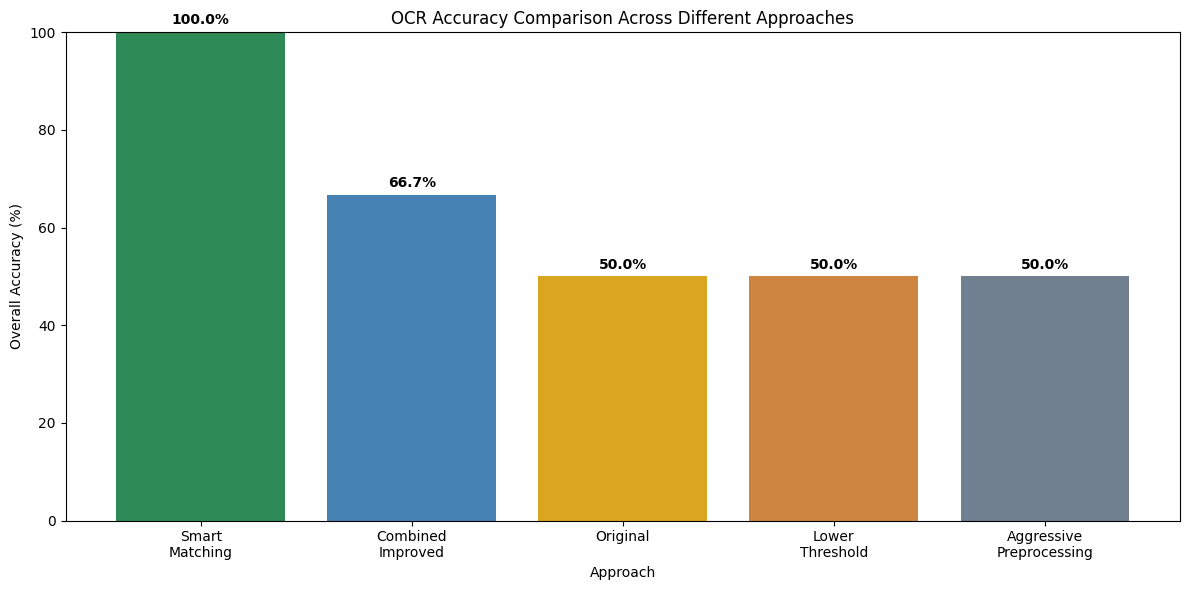

In [ ]:
# Create accuracy comparison chart
approach_names = [name for name, _ in sorted_approaches]
accuracies = [results["overall"]["accuracy"] for _, results in sorted_approaches]

plt.figure(figsize=(12, 6))
colors = ["#2E8B57", "#4682B4", "#DAA520", "#CD853F", "#708090"]
bars = plt.bar(
    range(len(approach_names)), accuracies, color=colors[: len(approach_names)]
)

plt.xlabel("Approach")
plt.ylabel("Overall Accuracy (%)")
plt.title("OCR Accuracy Comparison Across Different Approaches")
plt.xticks(
    range(len(approach_names)),
    [name.replace("_", "\n") for name in approach_names],
    rotation=0,
)
plt.ylim(0, 100)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 1,
        f"{accuracy:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()